In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [2]:
df = pd.read_csv("data/data.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   object 
dtypes: float

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


In [3]:
cardinality_all = df.nunique()
print(cardinality_all)

date               70
price            1741
bedrooms           10
bathrooms          26
sqft_living       566
sqft_lot         3113
floors              6
waterfront          2
view                5
condition           5
sqft_above        511
sqft_basement     207
yr_built          115
yr_renovated       60
street           4525
city               44
statezip           77
country             1
dtype: int64


In [4]:
#drop columns with high/low cardinality
df.drop(['country', 'street'], axis=1, inplace=True)

In [5]:
price_corr = df.select_dtypes(include='number').corr()['price'].sort_values(ascending=False)
print(price_corr)

price            1.000000
sqft_living      0.430410
sqft_above       0.367570
bathrooms        0.327110
view             0.228504
sqft_basement    0.210427
bedrooms         0.200336
floors           0.151461
waterfront       0.135648
sqft_lot         0.050451
condition        0.034915
yr_built         0.021857
yr_renovated    -0.028774
Name: price, dtype: float64


In [6]:
# Convert 'date' to datetime objects
df['date'] = pd.to_datetime(df['date'])

# Calculate the minimum date to use as a baseline
min_date = df['date'].min()

# Create a new feature: 'days_since_first_sale'
# This is a numerical feature representing the time passed in days.
df['days_since_first_sale'] = (df['date'] - min_date).dt.days

In [7]:
# To check the actual year range in your data:
df['date'] = pd.to_datetime(df['date'])
min_year = df['date'].dt.year.min()
max_year = df['date'].dt.year.max()

print(f"Sales range from {min_year} to {max_year}")

Sales range from 2014 to 2014


In [8]:
reference_year = 2014

# Determine the year of the last significant update (renovation or initial build)
# np.where checks if yr_renovated > 0. If True, use yr_renovated; otherwise, use yr_built.
df['last_update_year'] = np.where(df['yr_renovated'] > 0, df['yr_renovated'], df['yr_built'])

# Calculate 'age_at_sale'
df['age_at_sale'] = reference_year - df['last_update_year']

# Drop the original year columns
df.drop(['yr_renovated', 'yr_built', 'last_update_year'], axis=1, inplace=True)

In [9]:
df.drop('date', axis=1, inplace=True)

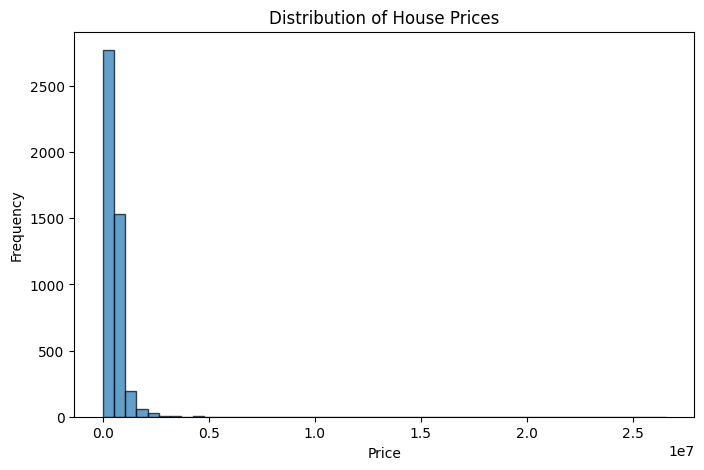

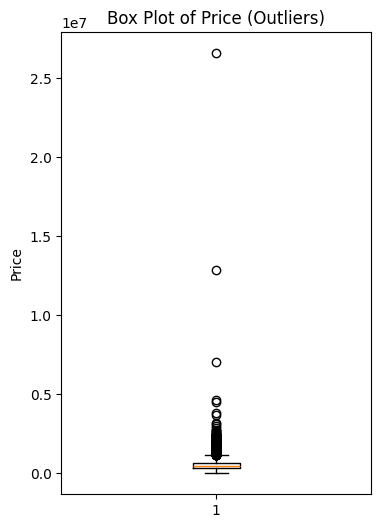

In [10]:
# 1a. Histogram of Price Distribution
plt.figure(figsize=(8, 5))
plt.hist(df['price'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of House Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# 1b. Box Plot of Price for Outlier Check
plt.figure(figsize=(4, 6))
plt.boxplot(df['price'])
plt.title('Box Plot of Price (Outliers)')
plt.ylabel('Price')
plt.show()

In [11]:
# Calculate key statistics for the price column
price_mean = df['price'].mean()
price_median = df['price'].median()
price_max = df['price'].max()

print(f"Mean Price: ${price_mean:,.2f}")
print(f"Median Price: ${price_median:,.2f}")
print(f"Maximum Price: ${price_max:,.2f}")

# Check the price at the 99th percentile
price_99th_percentile = df['price'].quantile(0.99)
print(f"Price at 99th Percentile: ${price_99th_percentile:,.2f}")

Mean Price: $551,962.99
Median Price: $460,943.46
Maximum Price: $26,590,000.00
Price at 99th Percentile: $2,005,220.00


In [12]:
# Use the calculated price cap (from your previous output)
price_cap = 2005220.00 

# Calculate the 99th percentile for the size features
sqft_living_cap = df['sqft_living'].quantile(0.99)
sqft_above_cap = df['sqft_above'].quantile(0.99)
sqft_basement_cap = df['sqft_basement'].quantile(0.99)

print(f"Sqft Living Cap (99th %): {sqft_living_cap:,.0f} sqft")
print(f"Sqft Above Cap (99th %): {sqft_above_cap:,.0f} sqft")
print(f"Sqft Basement Cap (99th %): {sqft_basement_cap:,.0f} sqft")

Sqft Living Cap (99th %): 5,180 sqft
Sqft Above Cap (99th %): 4,460 sqft
Sqft Basement Cap (99th %): 1,700 sqft


In [13]:
# --- A. Clip the Target Variable (Price) ---
# Any price above the 99th percentile is set to the 99th percentile value
df['price'] = np.where(df['price'] > price_cap, price_cap, df['price'])
print("Price column has been clipped.")

# --- B. Clip Highly-Correlated Size Features ---

# Clip sqft_living
df['sqft_living'] = np.where(
    df['sqft_living'] > sqft_living_cap,
    sqft_living_cap,
    df['sqft_living']
)

# Clip sqft_above
df['sqft_above'] = np.where(
    df['sqft_above'] > sqft_above_cap,
    sqft_above_cap,
    df['sqft_above']
)

# Clip sqft_basement
# Note: Since many houses have no basement (sqft_basement = 0), the clipping mostly affects the upper bound.
df['sqft_basement'] = np.where(
    df['sqft_basement'] > sqft_basement_cap,
    sqft_basement_cap,
    df['sqft_basement']
)

print("Key size features have been clipped to their 99th percentile values.")

Price column has been clipped.
Key size features have been clipped to their 99th percentile values.


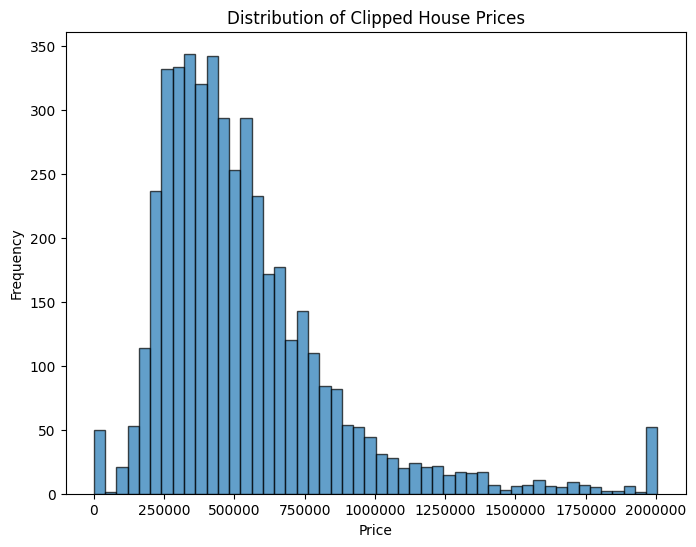

In [14]:
# Check the distribution of the newly clipped 'price' column
plt.figure(figsize=(8, 6))
plt.hist(df['price'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Clipped House Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.ticklabel_format(style='plain', axis='x') # Forces non-scientific notation
plt.show()

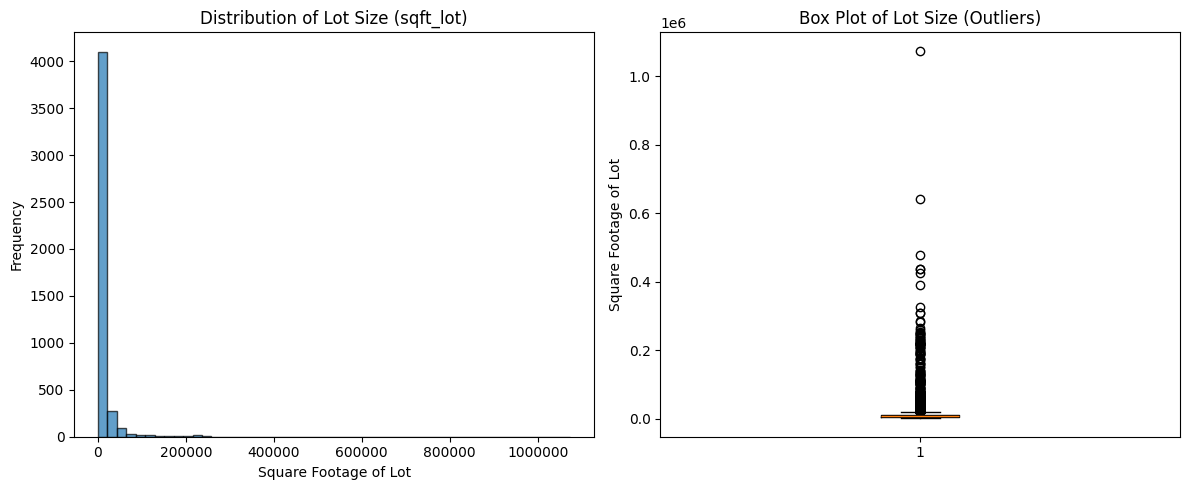

In [15]:
plt.figure(figsize=(12, 5))

# Subplot 1: Histogram for distribution
plt.subplot(1, 2, 1)
plt.hist(df['sqft_lot'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Lot Size (sqft_lot)')
plt.xlabel('Square Footage of Lot')
plt.ylabel('Frequency')
plt.ticklabel_format(style='plain') # Avoid scientific notation on X-axis

# Subplot 2: Box Plot for outliers
plt.subplot(1, 2, 2)
plt.boxplot(df['sqft_lot'])
plt.title('Box Plot of Lot Size (Outliers)')
plt.ylabel('Square Footage of Lot')

plt.tight_layout()
plt.show()

In [16]:
# Calculate key statistics for the sqft_lot column
sqft_lot_mean = df['sqft_lot'].mean()
sqft_lot_median = df['sqft_lot'].median()
sqft_lot_max = df['sqft_lot'].max()

# Check the sqft_lot at the 99th percentile
sqft_lot_99th_percentile = df['sqft_lot'].quantile(0.99)

print(f"Mean Sqft Lot: {sqft_lot_mean:,.2f} sqft")
print(f"Median Sqft Lot: {sqft_lot_median:,.2f} sqft")
print(f"Maximum Sqft Lot: {sqft_lot_max:,.2f} sqft")
print(f"Sqft Lot at 99th Percentile: {sqft_lot_99th_percentile:,.2f} sqft")

Mean Sqft Lot: 14,852.52 sqft
Median Sqft Lot: 7,683.00 sqft
Maximum Sqft Lot: 1,074,218.00 sqft
Sqft Lot at 99th Percentile: 203,455.49 sqft


In [17]:
# Define the cap value based on the calculated 99th percentile
sqft_lot_cap = 203455.49

# Apply clipping: any lot size above the cap is set to the cap value
df['sqft_lot'] = np.where(
    df['sqft_lot'] > sqft_lot_cap,
    sqft_lot_cap,
    df['sqft_lot']
)

print(f"Final feature clipping (sqft_lot) complete.")

Final feature clipping (sqft_lot) complete.


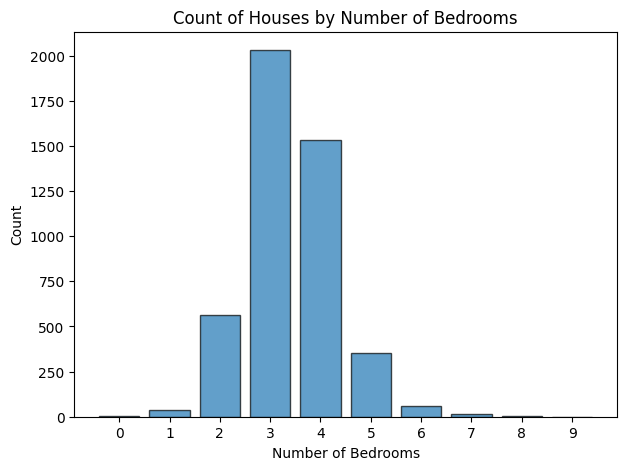

In [18]:
plt.figure(figsize=(7, 5))

# Get counts and plot as a bar chart
bedroom_counts = df['bedrooms'].value_counts().sort_index()
plt.bar(bedroom_counts.index, bedroom_counts.values, edgecolor='black', alpha=0.7)

plt.title('Count of Houses by Number of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Count')
plt.xticks(bedroom_counts.index)
plt.show()

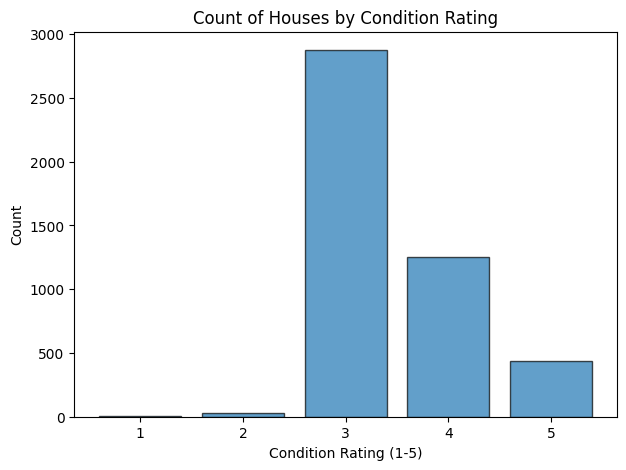

In [19]:
plt.figure(figsize=(7, 5))

# Get counts and plot as a bar chart
condition_counts = df['condition'].value_counts().sort_index()
plt.bar(condition_counts.index, condition_counts.values, edgecolor='black', alpha=0.7)

plt.title('Count of Houses by Condition Rating')
plt.xlabel('Condition Rating (1-5)')
plt.ylabel('Count')
plt.xticks(condition_counts.index)
plt.show()

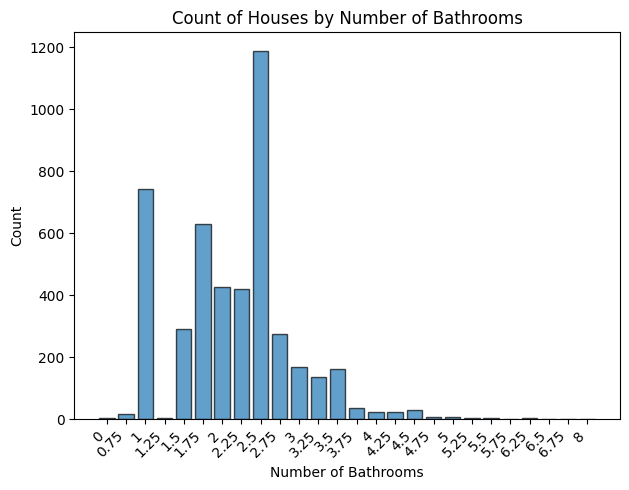

In [20]:
plt.figure(figsize=(12, 5))

# --- 1. Bar Chart for Distribution (FIXED CODE) ---
plt.subplot(1, 2, 1)

# Get counts, ensuring we sort by the numerical index first
bathroom_counts = df['bathrooms'].value_counts().sort_index()

# Use the numerical index (bathroom count) for plotting positions
x_positions = np.arange(len(bathroom_counts)) 
bar_labels = [f'{b:g}' for b in bathroom_counts.index] # Create clean labels like '1.5', '2.5', etc.

plt.bar(x_positions, bathroom_counts.values, 
        width=0.8, edgecolor='black', alpha=0.7)

plt.title('Count of Houses by Number of Bathrooms')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Count')

# Set the X-axis ticks to the clean labels
plt.xticks(x_positions, bar_labels, rotation=45, ha='right') 

plt.tight_layout()
plt.show()

In [21]:
import numpy as np

# --- Statistics for Bedrooms ---
bedrooms_mean = df['bedrooms'].mean()
bedrooms_median = df['bedrooms'].median()
bedrooms_max = df['bedrooms'].max()
bedrooms_99th_percentile = df['bedrooms'].quantile(0.99)

print("--- Bedrooms Statistics ---")
print(f"Mean Bedrooms: {bedrooms_mean:.2f}")
print(f"Median Bedrooms: {bedrooms_median:.0f}")
print(f"Maximum Bedrooms: {bedrooms_max:.0f}")
print(f"Bedrooms at 99th Percentile: {bedrooms_99th_percentile:.0f}")
print("---------------------------\n")

# --- Statistics for Condition Rating ---
condition_mean = df['condition'].mean()
condition_median = df['condition'].median()
condition_max = df['condition'].max()
condition_99th_percentile = df['condition'].quantile(0.99)

print("--- Condition Rating Statistics ---")
print(f"Mean Condition: {condition_mean:.2f}")
print(f"Median Condition: {condition_median:.0f}")
print(f"Maximum Condition: {condition_max:.0f}")
print(f"Condition at 99th Percentile: {condition_99th_percentile:.0f}")
print("---------------------------\n")

# --- Statistics for Bathrooms ---
bathrooms_mean = df['bathrooms'].mean()
bathrooms_median = df['bathrooms'].median()
bathrooms_max = df['bathrooms'].max()
bathrooms_99th_percentile = df['bathrooms'].quantile(0.99)

print("--- Bathrooms Statistics ---")
print(f"Mean Bathrooms: {bathrooms_mean:.2f}")
print(f"Median Bathrooms: {bathrooms_median:.1f}")
print(f"Maximum Bathrooms: {bathrooms_max:.1f}")
print(f"Bathrooms at 99th Percentile: {bathrooms_99th_percentile:.1f}")

--- Bedrooms Statistics ---
Mean Bedrooms: 3.40
Median Bedrooms: 3
Maximum Bedrooms: 9
Bedrooms at 99th Percentile: 6
---------------------------

--- Condition Rating Statistics ---
Mean Condition: 3.45
Median Condition: 3
Maximum Condition: 5
Condition at 99th Percentile: 5
---------------------------

--- Bathrooms Statistics ---
Mean Bathrooms: 2.16
Median Bathrooms: 2.2
Maximum Bathrooms: 8.0
Bathrooms at 99th Percentile: 4.5


In [22]:
# Define the cap value based on the calculated 99th percentile
bedrooms_cap = 6.0 

# Apply clipping: any number of bedrooms above the cap is set to 6
df['bedrooms'] = np.where(
    df['bedrooms'] > bedrooms_cap,
    bedrooms_cap,
    df['bedrooms']
)

print(f"Bedrooms feature has been successfully clipped at {bedrooms_cap:.0f}.")

Bedrooms feature has been successfully clipped at 6.


In [23]:
# Define the cap value based on the calculated 99th percentile
bathrooms_cap = 4.5

# Apply clipping: any number of bathrooms above the cap is set to 4.5
df['bathrooms'] = np.where(
    df['bathrooms'] > bathrooms_cap,
    bathrooms_cap,
    df['bathrooms']
)

print(f"Bathrooms feature has been successfully clipped at {bathrooms_cap:.1f}.")

Bathrooms feature has been successfully clipped at 4.5.


In [24]:
import numpy as np

# --- Statistics for Floors ---
floors_mean = df['floors'].mean()
floors_median = df['floors'].median()
floors_max = df['floors'].max()
floors_99th_percentile = df['floors'].quantile(0.99)

print("--- Floors Statistics ---")
print(f"Mean Floors: {floors_mean:.2f}")
print(f"Median Floors: {floors_median:.1f}")
print(f"Maximum Floors: {floors_max:.1f}")
print(f"Floors at 99th Percentile: {floors_99th_percentile:.1f}")
print("---------------------------\n")

# --- Statistics for View Rating ---
view_mean = df['view'].mean()
view_median = df['view'].median()
view_max = df['view'].max()
view_99th_percentile = df['view'].quantile(0.99)

print("--- View Rating Statistics ---")
print(f"Mean View: {view_mean:.2f}")
print(f"Median View: {view_median:.0f}")
print(f"Maximum View: {view_max:.0f}")
print(f"View at 99th Percentile: {view_99th_percentile:.0f}")

--- Floors Statistics ---
Mean Floors: 1.51
Median Floors: 1.5
Maximum Floors: 3.5
Floors at 99th Percentile: 3.0
---------------------------

--- View Rating Statistics ---
Mean View: 0.24
Median View: 0
Maximum View: 4
View at 99th Percentile: 4


In [25]:
# Clip floors (cap at 3.0)
floors_cap = 3.0
df['floors'] = np.where(df['floors'] > floors_cap, floors_cap, df['floors'])

# Clip bathrooms (cap at 4.5, which was confirmed in the previous step)
bathrooms_cap = 4.5
df['bathrooms'] = np.where(df['bathrooms'] > bathrooms_cap, bathrooms_cap, df['bathrooms'])

print("Final feature clipping (floors and bathrooms) complete.")

Final feature clipping (floors and bathrooms) complete.


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price                  4600 non-null   float64
 1   bedrooms               4600 non-null   float64
 2   bathrooms              4600 non-null   float64
 3   sqft_living            4600 non-null   float64
 4   sqft_lot               4600 non-null   float64
 5   floors                 4600 non-null   float64
 6   waterfront             4600 non-null   int64  
 7   view                   4600 non-null   int64  
 8   condition              4600 non-null   int64  
 9   sqft_above             4600 non-null   float64
 10  sqft_basement          4600 non-null   float64
 11  city                   4600 non-null   object 
 12  statezip               4600 non-null   object 
 13  days_since_first_sale  4600 non-null   int64  
 14  age_at_sale            4600 non-null   int64  
dtypes: f

In [27]:
# Check for the count of zero prices
zero_price_count = (df['price'] == 0.0).sum()

print(f"Number of houses with a price of $0.00: {zero_price_count}")

Number of houses with a price of $0.00: 49


In [28]:
# 1. Create a subset of the DataFrame where price is zero
zero_price_subset = df[df['price'] == 0.0]

# 2. Check key statistics for size features in this subset
print("--- Feature Statistics for Houses with $0.00 Price ---")
print(f"Count of Zero-Priced Houses: {len(zero_price_subset)}")
print("\nKey Feature Min/Max:")

# Display min and max of key features for the subset
for col in ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot']:
    min_val = zero_price_subset[col].min()
    max_val = zero_price_subset[col].max()
    
    # Check if all values are identical (like all zero)
    if min_val == max_val:
        print(f"  {col:<11}: All {min_val:g}")
    else:
        print(f"  {col:<11}: Min={min_val:g}, Max={max_val:g}")

# Check the count of unique cities for location variety
print(f"Unique Cities: {zero_price_subset['city'].nunique()}")

--- Feature Statistics for Houses with $0.00 Price ---
Count of Zero-Priced Houses: 49

Key Feature Min/Max:
  bedrooms   : Min=1, Max=6
  bathrooms  : Min=1, Max=4.5
  sqft_living: Min=720, Max=5180.1
  sqft_lot   : Min=3500, Max=188200
Unique Cities: 21


In [29]:
# Find the smallest non-zero price in the dataset
min_non_zero_price = df[df['price'] > 0]['price'].min()

# Replace all 49 zero prices with the smallest non-zero price found
df['price'] = np.where(df['price'] == 0, min_non_zero_price, df['price'])

print(f"Successfully replaced 49 zero prices with the minimum non-zero price: ${min_non_zero_price:,.2f}")

Successfully replaced 49 zero prices with the minimum non-zero price: $7,800.00


In [30]:
# Apply the Log Transformation to the cleaned (clipped) price column
df['log_price'] = np.log(df['price'])

# Drop the original 'price' column, as 'log_price' is the new target variable (y)
df.drop('price', axis=1, inplace=True)

print("Log transformation complete. 'log_price' is the new target.")

Log transformation complete. 'log_price' is the new target.


In [31]:
X = df.drop('log_price', axis=1)
y = df['log_price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [32]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)

mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean price:", round(y_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean price: 13.02
Baseline MAE: 0.46


In [37]:
categorical_features = ['city', 'statezip']

numerical_features = [
    'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
    'sqft_above', 'sqft_basement', 'waterfront', 'view', 'condition',
    'days_since_first_sale', 'age_at_sale'
]

preprocessor = ColumnTransformer(
    transformers=[
        # OHE for city and statezip
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        # Pass through the numerical features without scaling (since log transformation handles skewness)
        ('num', 'passthrough', numerical_features)
    ],
    remainder='drop' 
)

model = make_pipeline(
    preprocessor,
    LinearRegression()
)

In [38]:
model.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('linearregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [45]:
y_train_pred = model.predict(X_train)

In [46]:
mae_training = mean_absolute_error(y_train, y_train_pred)
print("Training MAE:", round(mae_training, 2))

Training MAE: 0.21


In [47]:
y_test_pred = model.predict(X_test)

mae_test = mean_absolute_error(y_test, y_test_pred)

print(f"MAE (Test): {mae_test:.4f} (Log Units)")

MAE (Test): 0.2271 (Log Units)


In [49]:
r2_test = r2_score(y_test, y_test_pred)
print(f"R-squared (Test): {r2_test:.4f}")

R-squared (Test): 0.3795


In [52]:
# BASELINE in real prices
y_mean_log = y_train.mean()                   # mean in log units
y_mean_real = np.exp(y_mean_log)              # convert to real price

y_pred_baseline_real = np.repeat(y_mean_real, len(y_train))

mae_baseline = mean_absolute_error(np.exp(y_train), y_pred_baseline_real)

print("Mean price (real):", round(y_mean_real, 2))
print("Baseline MAE (real):", round(mae_baseline, 2))


# TRAIN SET predictions
y_train_pred_log = model.predict(X_train)     # log units
y_train_pred_real = np.exp(y_train_pred_log)  # convert to real price

mae_train = mean_absolute_error(np.exp(y_train), y_train_pred_real)
print("Training MAE (real):", round(mae_train, 2))


# TEST SET predictions
y_test_pred_log = model.predict(X_test)       # log units
y_test_pred_real = np.exp(y_test_pred_log)    # convert to real price

mae_test = mean_absolute_error(np.exp(y_test), y_test_pred_real)
print(f"MAE (Test, real price): {mae_test:.4f}")

Mean price (real): 450117.06
Baseline MAE (real): 222535.36
Training MAE (real): 98742.16
MAE (Test, real price): 109130.6446


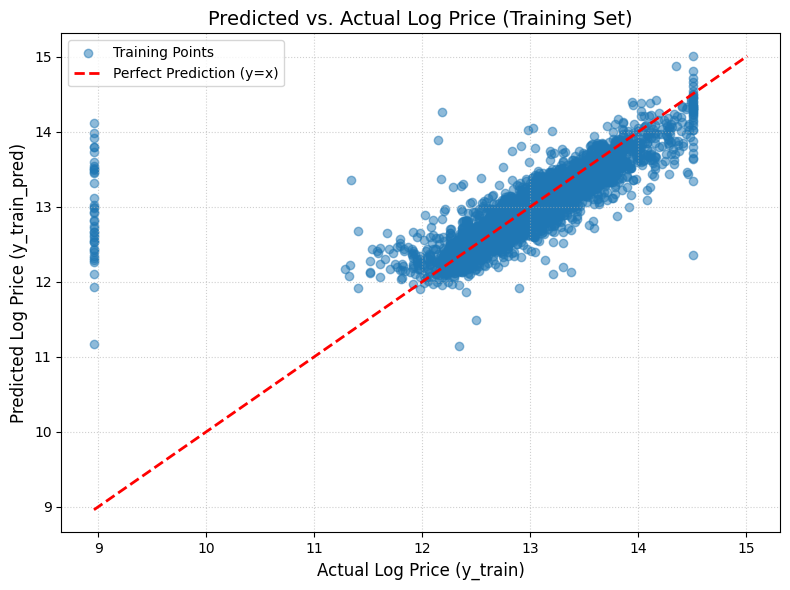

In [53]:
# Create the plot for the training set
plt.figure(figsize=(8, 6))

# Scatter plot of Actual vs. Predicted values
plt.scatter(y_train, y_train_pred, 
            alpha=0.5, 
            color='#1f77b4', 
            label='Training Points')

# Plot the line of perfect prediction (y=x)
# This line shows where predictions should ideally land
min_val = min(y_train.min(), y_train_pred.min())
max_val = max(y_train.max(), y_train_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 
         color='red', 
         linestyle='--', 
         linewidth=2, 
         label='Perfect Prediction (y=x)')

plt.title('Predicted vs. Actual Log Price (Training Set)', fontsize=14)
plt.xlabel('Actual Log Price (y_train)', fontsize=12)
plt.ylabel('Predicted Log Price (y_train_pred)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

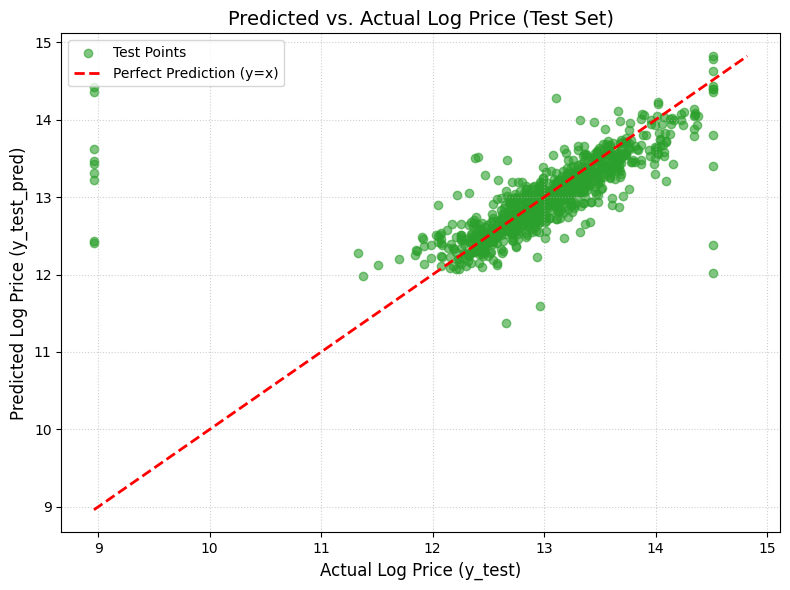

In [56]:
# Create the plot for the test set
plt.figure(figsize=(8, 6))

# Scatter plot of Actual vs. Predicted values (using Test Set variables)
plt.scatter(y_test, y_test_pred, 
            alpha=0.6, 
            color='#2ca02c', 
            label='Test Points')

# Plot the line of perfect prediction (y=x)
# Use the range of the Test Set data for plotting limits
min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 
         color='red', 
         linestyle='--', 
         linewidth=2, 
         label='Perfect Prediction (y=x)')

plt.title('Predicted vs. Actual Log Price (Test Set)', fontsize=14)
plt.xlabel('Actual Log Price (y_test)', fontsize=12)
plt.ylabel('Predicted Log Price (y_test_pred)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

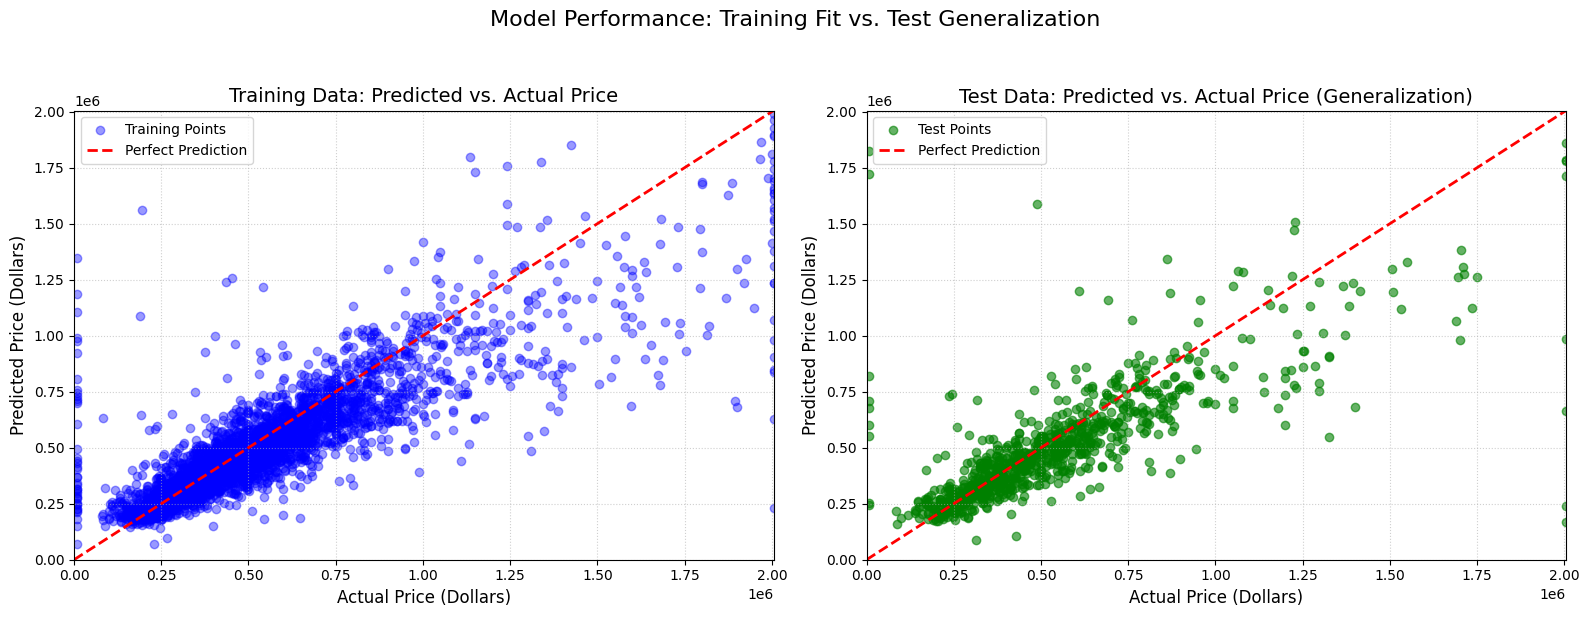

In [55]:
# 1. Convert all log-transformed data back to actual dollar price (Price = exp(log_price))
y_train_price = np.exp(y_train)
y_train_pred_price = np.exp(y_train_pred)
y_test_price = np.exp(y_test)
y_test_pred_price = np.exp(y_test_pred)

# Determine global max price for the y=x line
max_price = max(y_train_price.max(), y_test_price.max())
min_price = 0 # Price cannot be negative

# 2. Setup the figure with two subplots side-by-side
plt.figure(figsize=(16, 6))

# --- SUBPLOT 1: TRAINING DATA ---
plt.subplot(1, 2, 1) # (rows, columns, plot number)
plt.scatter(y_train_price, y_train_pred_price, 
            alpha=0.4, 
            color='blue', 
            label='Training Points')
plt.plot([min_price, max_price], [min_price, max_price], 
         color='red', 
         linestyle='--', 
         linewidth=2, 
         label='Perfect Prediction')

plt.title('Training Data: Predicted vs. Actual Price', fontsize=14)
plt.xlabel('Actual Price (Dollars)', fontsize=12)
plt.ylabel('Predicted Price (Dollars)', fontsize=12)
plt.xlim(min_price, max_price)
plt.ylim(min_price, max_price)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()


# --- SUBPLOT 2: TEST DATA ---
plt.subplot(1, 2, 2)
plt.scatter(y_test_price, y_test_pred_price, 
            alpha=0.6, 
            color='green', 
            label='Test Points')
plt.plot([min_price, max_price], [min_price, max_price], 
         color='red', 
         linestyle='--', 
         linewidth=2, 
         label='Perfect Prediction')

plt.title('Test Data: Predicted vs. Actual Price (Generalization)', fontsize=14)
plt.xlabel('Actual Price (Dollars)', fontsize=12)
plt.ylabel('Predicted Price (Dollars)', fontsize=12)
plt.xlim(min_price, max_price)
plt.ylim(min_price, max_price)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()

plt.suptitle('Model Performance: Training Fit vs. Test Generalization', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [58]:
# 1. EXTRACT COEFFICIENTS AND INTERCEPT
linear_regressor = model.named_steps['linearregression']
intercept = linear_regressor.intercept_
coefficients = linear_regressor.coef_

# 2. EXTRACT ALIGNED FEATURE NAMES
preprocessor = model.named_steps['columntransformer']
numerical_features_used = preprocessor.transformers_[1][2] # Get numerical names from transformer tuple
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numerical_features_used, ohe_feature_names])

# 3. CREATE AND ORGANIZE DATAFRAME
coefficients_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

# 4. PRINT CORE RESULTS
print(f"Intercept (Log Price Base): {intercept:.4f}")
print("\n--- TOP 10 POSITIVE PRICE DRIVERS ---")
print(coefficients_df.head(10).to_string(index=False, float_format='{:.4f}'.format))

print("\n--- TOP 10 NEGATIVE PRICE DRIVERS ---")
print(coefficients_df.tail(10).sort_values(by='Coefficient', ascending=True).to_string(index=False, float_format='{:.4f}'.format))

Intercept (Log Price Base): 12.0829

--- TOP 10 POSITIVE PRICE DRIVERS ---
          Feature  Coefficient
statezip_WA 98006       0.7606
city_Maple Valley       0.7419
      city_SeaTac       0.6279
statezip_WA 98004       0.6064
statezip_WA 98072       0.5417
statezip_WA 98070       0.5360
statezip_WA 98102       0.5263
statezip_WA 98002       0.5131
     city_Seattle       0.4542
statezip_WA 98056       0.3749

--- TOP 10 NEGATIVE PRICE DRIVERS ---
                Feature  Coefficient
city_Beaux Arts Village      -0.9524
         city_Sammamish      -0.7068
      statezip_WA 98122      -0.6921
      statezip_WA 98051      -0.6526
            city_Renton      -0.5780
      statezip_WA 98118      -0.4681
          city_Bellevue      -0.4353
      statezip_WA 98055      -0.4334
      statezip_WA 98125      -0.4272
      statezip_WA 98052      -0.4079
